In [1]:
import pandas as pd
from IPython.display import display
from matplotlib import pyplot as plt
import plotly.graph_objs as go

In [2]:
MAIN_DIR = "src/data/"

In [3]:
# Load the CSV
ufcfights = pd.read_csv(MAIN_DIR + "ufcfights_update.csv", index_col=False)

# Sort with the most recent at the bottom
ufcfights = ufcfights.sort_index(ascending=False)

# Create unique event IDs
unique_events = ufcfights[['event']].drop_duplicates().reset_index(drop=True)
unique_events['event_id'] = range(1, len(unique_events) + 1)

# inner join of ufc fights and unique events on 'event' key
ufcfights = ufcfights.merge(unique_events, on='event')

# Drop unnecessary columns
ufcfights.drop(columns=["method", "round", "time"], inplace=True)

In [4]:
# Initialize Elo ratings
initial_elo = 1000
elo_ratings = {}
k_factor = 200 # up to 200 as fighters have matches at least 5x rarelier than in chess - for better comparison

In [5]:
# Function to calculate the expected score
def expected_score(elo_a, elo_b):
    return 1 / (1 + 10**((elo_b - elo_a) / 400))

# Function to update Elo ratings
def update_elo(winner_elo, loser_elo, k_factor):
    expected_win = expected_score(winner_elo, loser_elo)
    new_winner_elo = winner_elo + k_factor * (1 - expected_win)
    new_loser_elo = loser_elo + k_factor * (0 - (1 - expected_win))
    return new_winner_elo, new_loser_elo

In [ ]:
# Add columns for Elo ratings
ufcfights['fighter_1_elo_start'] = 0
ufcfights['fighter_2_elo_start'] = 0
ufcfights['fighter_1_elo_end'] = 0
ufcfights['fighter_2_elo_end'] = 0

# Calculate Elo ratings for each match
for index, row in ufcfights.iterrows():
    fighter_1 = row['fighter_1']
    fighter_2 = row['fighter_2']

    # Initialize Elo ratings if fighters are encountered for the first time - moved to list of elos
    if fighter_1 not in elo_ratings:
        elo_ratings[fighter_1] = [initial_elo]
    if fighter_2 not in elo_ratings:
        elo_ratings[fighter_2] = [initial_elo]

    # Get starting Elo ratings
    fighter_1_elo_start = elo_ratings[fighter_1][-1]
    fighter_2_elo_start = elo_ratings[fighter_2][-1]

    # Record starting Elo ratings
    ufcfights.at[index, 'fighter_1_elo_start'] = fighter_1_elo_start
    ufcfights.at[index, 'fighter_2_elo_start'] = fighter_2_elo_start

    # Update Elo based on the result
    if row['result'] == 'win':  # Fighter 1 wins
        new_fighter1_elo, new_fighter2_elo = update_elo(fighter_1_elo_start, fighter_2_elo_start, k_factor)
    elif row["result"] == 'draw':  # Draw
        new_fighter1_elo, new_fighter2_elo = update_elo(fighter_1_elo_start, fighter_2_elo_start, k_factor / 2)
    else:  # No contest
        new_fighter1_elo, new_fighter2_elo = fighter_1_elo_start, fighter_2_elo_start

    # Record updated Elo ratings
    ufcfights.at[index, 'fighter_1_elo_end'] = new_fighter1_elo
    ufcfights.at[index, 'fighter_2_elo_end'] = new_fighter2_elo

    # Update Elo ratings in the dictionary
    elo_ratings[fighter_1].append(new_fighter1_elo)
    elo_ratings[fighter_2].append(new_fighter2_elo)

# ------------------------------

In [7]:
import plotly.graph_objs as go
import pandas as pd

def plot_elo_vs_time(fighter_name, fighter_matches, plot_param=None):
    # If event dates are available, use them for the x-axis, otherwise use an index
    if 'event_date' in fighter_matches.columns:
        x_axis = fighter_matches['event_date']
    else:
        x_axis = fighter_matches.index  # Creating a time index

    # Extract Elo ratings and results
    elo_after_matches = fighter_matches['own elo after'].round(2)
    results = fighter_matches['result']

    # Define colors for wins and losses
    colors = ['green' if result == 'win' else 'red' for result in results]

    # Create an interactive Plotly plot
    fig = go.Figure()

    # Add trace for Elo ratings over time
    fig.add_trace(go.Scatter(
        x=x_axis, 
        y=elo_after_matches, 
        mode='lines+markers',
        marker=dict(color=colors, size=10),
        line=dict(color='blue', width=2),
        name=f'{fighter_name} Elo Rating',
        hoverinfo='text',
        text=[f"Event: {event}, Result: {result}, Elo: {elo:.2f}" 
              for event, result, elo in zip(fighter_matches['event'], results, elo_after_matches)]
    ))

    # Customize layout
    fig.update_layout(
        title=f"Elo Rating over Time for {fighter_name}",
        xaxis_title='Event Date' if 'event_date' in fighter_matches.columns else 'Match Number',
        yaxis_title='Elo Rating',
        legend_title="Legend",
        hovermode="closest",
        plot_bgcolor='rgba(0,0,0,0)',
        paper_bgcolor='rgba(0,0,0,0)',
        font=dict(size=14),
        xaxis=dict(showgrid=True, zeroline=False),
        yaxis=dict(showgrid=True, zeroline=False),
    )
    
    fighter_name_save = fighter_name.replace(" ", "_")
    if plot_param:
        if plot_param["save_as_html"]: 
            fig.write_html(f"src/figs/fighter_{fighter_name_save}_elo_plot.html")

    # Show the figure
    fig.show()

In [8]:
def get_fighter_info(fighter_name, elo_ratings, ufcfights, initial_elo=1000, plot_param=None):
    # Check if the fighter exists in the Elo ratings dictionary
    if fighter_name in elo_ratings:
        elo = elo_ratings[fighter_name]
    else:
        elo = initial_elo

    # Find all matches where the fighter appeared as either fighter_1 or fighter_2
    fighter_matches_1 = ufcfights[(ufcfights['fighter_1'] == fighter_name)][['event', 'fighter_2', 'result',
    'event_id', 'fighter_1_elo_start', 'fighter_2_elo_start', 'fighter_1_elo_end']].rename(columns={'fighter_2': 'opponent',
    'fighter_2_elo_start': 'opponent elo', 'fighter_1_elo_start': 'own elo', 'fighter_1_elo_end': 'own elo after'})
    
    fighter_matches_2 = ufcfights[(ufcfights['fighter_2'] == fighter_name)][['event', 'fighter_1', 'result',
    'event_id', 'fighter_1_elo_start', 'fighter_2_elo_start', 'fighter_2_elo_end']].rename(columns={'fighter_1': 'opponent',
    'fighter_1_elo_start': 'opponent elo', 'fighter_2_elo_start': 'own elo', 'fighter_2_elo_end': 'own elo after'})
    fighter_matches_2['result'] = fighter_matches_2['result'].str.replace('win','loss')
    
    fighter_matches = pd.concat([fighter_matches_1, fighter_matches_2]).reset_index()
    
    
    # Return Elo rating and their matches
    if not fighter_matches.empty:
        print(f"{fighter_name}'s current Elo rating: {elo[-1]}\n")
        print(f"{fighter_name}'s highest Elo rating: {max(elo)}\n")
        print(f"{fighter_name}'s matches:")
        display(fighter_matches)
        print(f"{fighter_name}'s elo history:\n")
        if plot_param:
            if plot_param["plot_mode"]==1: fighter_matches['own elo after'].plot(marker='o')
            elif plot_param["plot_mode"]==2: plot_elo_vs_time(fighter_name, fighter_matches, plot_param)
    else:
        print(f"{fighter_name} has no recorded matches.")

Royce Gracie's current Elo rating: 1373.9098983465929

Royce Gracie's highest Elo rating: 1561.7608360472366

Royce Gracie's matches:


,index,event,opponent,result,event_id,own elo,opponent elo,own elo after
0,2,UFC 1: The Beginning,Art Jimmerson,win,1,1000.000000,1000.000000,1100.000000
1,5,UFC 1: The Beginning,Ken Shamrock,win,1,1100.000000,1100.000000,1200.000000
2,7,UFC 1: The Beginning,Gerard Gordeau,win,1,1200.000000,1200.000000,1300.000000
3,15,UFC 2: No Way Out,Minoki Ichihara,win,2,1300.000000,1000.000000,1330.195911
4,19,UFC 2: No Way Out,Jason DeLucia,win,2,1330.195911,1171.987000,1387.566265
5,21,UFC 2: No Way Out,Remco Pardoel,win,2,1387.566265,1200.000000,1438.278134
6,22,UFC 2: No Way Out,Patrick Smith,win,2,1438.278134,1255.207751,1489.975897
7,26,UFC 3: The American Dream,Kimo Leopoldo,win,3,1489.975897,1000.000000,1501.220879
8,32,UFC 4: Revenge of the Warriors,Ron van Clief,win,4,1501.220879,1000.000000,1511.798294
9,36,UFC 4: Revenge of the Warriors,Keith Hackney,win,4,1511.798294,1171.987000,1536.576002


Royce Gracie's elo history:



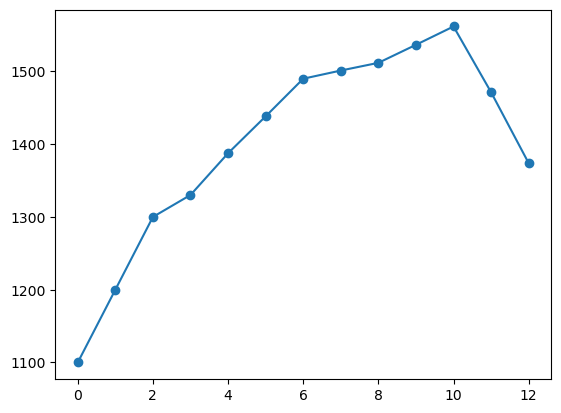

In [9]:
plot_param = {
    "plot_mode": 1,
    "save_as_html": True
}

get_fighter_info("Royce Gracie",elo_ratings, ufcfights, plot_param=plot_param)

# Best elos in history

In [10]:
min_max_elos = [{'fighter': k, 'max_elo': max(v), 'min_elo': min(v), 'last': v[-1]} for k, v in elo_ratings.items()]
min_max_elos = pd.DataFrame.from_records(min_max_elos)

### All time

In [11]:
min_max_elos.sort_values('max_elo', ascending=False).head(20).round(2)

,fighter,max_elo,min_elo,last
1440,Islam Makhachev,2109.54,1000.00,2109.54
1461,Kamaru Usman,2092.58,1000.00,1676.73
1364,Leon Edwards,2083.90,928.65,1936.75
1554,Belal Muhammad,2053.19,946.68,2053.19
599,Jon Jones,2033.86,1000.00,2033.86
311,Georges St-Pierre,2012.30,1000.00,2012.30
1616,Alexander Volkanovski,2010.56,1000.00,1700.03
927,Khabib Nurmagomedov,1992.11,1000.00,1992.11
1208,Aljamain Sterling,1990.75,1000.00,1822.01
883,Stipe Miocic,1990.23,1000.00,1837.11


### Current

In [12]:
min_max_elos.sort_values('last', ascending=False).head(20).round(2)

,fighter,max_elo,min_elo,last
1440,Islam Makhachev,2109.54,1000.00,2109.54
1554,Belal Muhammad,2053.19,946.68,2053.19
599,Jon Jones,2033.86,1000.00,2033.86
311,Georges St-Pierre,2012.30,1000.00,2012.30
927,Khabib Nurmagomedov,1992.11,1000.00,1992.11
1509,Francis Ngannou,1989.11,1000.00,1989.11
935,Max Holloway,1937.75,965.43,1937.75
1364,Leon Edwards,2083.90,928.65,1936.75
1745,Merab Dvalishvili,1914.85,814.65,1914.85
2107,Dricus Du Plessis,1892.05,1000.00,1892.05
